<h1>Import necessary libraries</h1>

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import LeakyReLU , ReLU, PReLU
from tensorflow.keras.layers import Conv2D ,Conv2DTranspose
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import numpy as np
from PIL import Image
import os 
import matplotlib.pyplot as plt

# import custom callbacks defined in 'utils/callbacks.py'
from utils.callbacks import save_images, checkpoint_callback 

<h1>Load dataset</h1>

We will be using `image_dataset_from_directory` function from keras to load the dataset from the directory which returns a `tf.data.dataset`
The dataset is then normalized to a range [-1,1] same as the tanh function

In [3]:
data_path = "images/"

In [4]:
# Loading the data from directory:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_path, 
    label_mode=None, 
    color_mode='rgb',
    batch_size=128,
    image_size=(96, 96),
    shuffle=True
)

# Mapping some transformations to make the data lighter and easier to prep.
train_ds = train_ds.map(lambda x: ((x/127.5)-1)) 

Found 63565 files belonging to 1 classes.
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


<h1>Define Generator and Discriminator</h1>

In [5]:
# Weights initializer
init = tf.keras.initializers.RandomNormal(stddev=0.02)

In [6]:
# Building a Generator:
def build_generator(seed_size):
    """
    Builds the generator model
    
    Parameters:
        seed_size: size of the random vector fed into the generator
    
    Returns:
        model: keras model representing the generator
    """
    model = Sequential()
  
    # Block - 1
    model.add(Dense(6*6*1024,kernel_initializer=init,input_dim=seed_size))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Reshape((6,6,1024))) # Resulting shape = (6,6,1024) 

    # Block - 2
    model.add(Conv2DTranspose(512,kernel_size=5,strides=2,padding='same',use_bias=False,kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(ReLU())  # Resulting shape = (12,12,512)

    # Block - 3
    model.add(Conv2DTranspose(256,kernel_size=5,strides=2,padding='same',use_bias=False,kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(ReLU()) # Resulting shape = (24,24,256)

    # Block - 4
    model.add(Conv2DTranspose(128,kernel_size=3,strides=2,padding='same',use_bias=False,kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(ReLU()) # Resulting shape = (48,48,128)

    # Block - 5
    model.add(Conv2DTranspose(3,kernel_size=3,strides=2,padding='same',use_bias=False,kernel_initializer=init))
    model.add(Activation('tanh')) # Resulting shape = (96,96,3)

    return model

In [7]:
def build_discriminator(image_length,image_channels):
    
    """
    Builds the generator model
    
    Parameters:
        image_length: length of a side of the square image
        image_channels: number of channels in the image
    
    Returns:
        model: keras model representing the discriminator
    """
    
    model = Sequential()
  
    # Block - 1
    model.add(Conv2D(64,kernel_size=3,strides=2,padding='same',use_bias=False,input_shape=(image_length,image_length,image_channels),kernel_initializer=init))
    model.add(LeakyReLU(alpha=0.2)) # Resulting shape = (32,32,64)

    # Block - 2
    model.add(Conv2D(128,kernel_size=3,strides=2,padding='same',use_bias=False,kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2)) # Resulting shape = (16,16,128)

    # Block - 3
    model.add(Conv2D(256,kernel_size=5,strides=2,padding='same',use_bias=False,kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2)) # Resulting shape = (8,8,256)

    # Block - 4
    model.add(Conv2D(512,kernel_size=5,strides=2,padding='same',use_bias=False,kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2)) # Resulting shape = (4,4,512)

    # Block - 5
    model.add(Conv2D(1,kernel_size=4,strides=1,padding='valid',use_bias=False,kernel_initializer=init))
    model.add(Flatten())
    model.add(Activation('sigmoid'))

    return model

<h1>Define Keras Model</h1>

As the DCGAN follows a different training step compared to normal feed forward neural networks we can define the training step by first sub-classing the `keras.Model` class and then overwrite the `train_step()` function. By doing so the `model.fit()` function follows our custom training step. This way we would not have to write explicit for-loop for the epochs and keras callbacks can also be used.  

Since the generator and discriminator follow CNN architectures, they can be defined using keras `Sequential`. The backpropagation for the generator and discriminator are then taken care of by `tf.GradientTape()`

One-sided-label smoothing has been implemented (only for discriminator) to prevent the discriminator from overpowering the generator. Specifying this parameter changes the labels for real images from `1` to `(1-smooth)`. 

`smooth` parameter defined in the `discriminator_loss()` function takes care of this

In [8]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

In [9]:
class DCGAN(keras.Model):
    """Subclass of the keras.Model class to define custom training step and loss functions"""
    
    
    def __init__(self,seed_size,image_length,image_channels,**kwargs):
        """
        Parameters:
            seed_size: size of the random vector for the generator
            image_length: length of a side of the square image
            image_channels: number of channels in the image
        """
        super(DCGAN,self).__init__(**kwargs)

        self.generator = build_generator(seed_size)
        self.discriminator = build_discriminator(image_length,image_channels)
        self.seed_size = seed_size
        
        
   # Train generator to give realistic images and penalize it for giving images being classified as fake by the discriminator     
    def generator_loss(self,fake_output):
        """
        Parameters:
            fake_output: Tensor containing the respective discriminator's predictions for the batch of images produced
            by generator (fake iamges).
            
        Returns:
            cross entropy loss between labels for real images (1's) and the discriminator's estimate 
        """
        
        # The objective is to penalize the generator whenever it produces images which the discriminator classifies as 'fake'
        return cross_entropy(tf.ones_like(fake_output), fake_output)

       
        # smooth parameter is used to induce one sided label smoothing. It can be tuned accordingly
    def discriminator_loss(self,real_output, fake_output,smooth=0.1):
        """
        Parameters: 
            real_output: Tensor containing the respective discriminator's predictions for the batch of images taken from
                        the dataset (real images).
            fake_output: Tensor containing the respective discriminator's predictions for the batch of images produced
                        by generator (fake images).
        
        Returns:
            total_loss: Loss of the discriminator for misclassifying images
        """
        # label for real image is (1-smooth)
        real_loss = cross_entropy(tf.ones_like(real_output)*(1-smooth), real_output) 
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss
    
    def compile(self,generator_optimizer,discriminator_optimizer):
        """
        configures model for training by adding optimizers
        
        Parameters: 
            generator_optimizer: keras optimizer to be used to train generator.
            discriminator_optimizer: keras optimizer to be used to train discriminator.
        """
        super(DCGAN, self).compile()
        self.generator_optimizer = generator_optimizer
        self.discriminator_optimizer = discriminator_optimizer
        
    @tf.function    
    def train_step(self,data):
        
        """
        Takes in training data and does a forward pass
        
        Parameters:
            data: a batch from the training data.
        Returns:
            gen_loss: loss associated with the generator.
            disc_loss: loss associated with the discriminator.
            
        """
            
        batch_size = tf.shape(data)[0]
        
        # feed a random input to generator
        seed = tf.random.normal(shape=(batch_size,self.seed_size))
        
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            
            # generate image using generator
            generated_image = self.generator(seed, training = True)
        
            # discriminator's prediction for real image
            real_output = self.discriminator(data,training = True)
            
            # discriminator's estimate for fake image
            fake_output = self.discriminator(generated_image,training = True) 
            
            # compute loss
            gen_loss = self.generator_loss(fake_output)
            disc_loss = self.discriminator_loss(real_output,fake_output)

            # optimize generator first
            generator_grad = gen_tape.gradient(gen_loss,self.generator.trainable_variables)
            discriminator_grad = disc_tape.gradient(disc_loss,self.discriminator.trainable_variables)

            # optimize discriminator after generator
            self.generator_optimizer.apply_gradients(zip(generator_grad,self.generator.trainable_variables))
            self.discriminator_optimizer.apply_gradients(zip(discriminator_grad,self.discriminator.trainable_variables))
        
        return {
            "generator loss": gen_loss,
            "discriminator_loss": disc_loss
        }

While training, two custom callbacks `save_images` and `checkpoint_callback` which are defined in `utils/callbacks.py`.

1. `save_images`: The callback saves images to the disk by the generator using a fixed random normal seed (`fixed_seed`). This way the progress of the generator can be monitored every epoch. It generates a grid of `NUM_ROWS` \* `NUM_COLS` number of images with a margin set by `MARGIN`.  


2. `checkpoint_callback`: This callback periodically saves the weights of the generator and discriminator every epoch. This is done to help saving the DCGAN's progress if training is stopped accidentally

In [10]:
# parameters and hyperparameters
image_length = 96
image_channels = 3
batch_size = 128
seed_size = 128

NUM_ROWS = 4  
NUM_COLS = 7
MARGIN = 16

# Ideally, a model is just matrix multiplication, so having the same noise will generate the same images. That is why I am setting a seed.
fixed_seed = tf.random.normal(shape=(NUM_ROWS * NUM_COLS, seed_size))

### Initialize the DCGAN

In [11]:
generator_optimizer = Adam(learning_rate=0.0002,beta_1=0.5)
discriminator_optimizer = Adam(learning_rate=0.0002,beta_1=0.5)

dcgan = DCGAN(seed_size,image_length,image_channels)
dcgan.compile(generator_optimizer,discriminator_optimizer)

/home/workstation/miniconda3/envs/TensorFlow/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


<h1>Training</h1>

In [12]:
with tf.device('/GPU:0'):
    
    #uncomment the next two lines if not training from scratch
    dcgan.generator.load_weights("Weights/generator_weights-test.h5")
    dcgan.discriminator.load_weights("Weights/discriminator_weights-test.h5")
    
    history = dcgan.fit(train_ds,epochs=18,batch_size=batch_size,
                        callbacks=[
                            save_images(noise=fixed_seed,num_rows=NUM_ROWS,num_cols=NUM_COLS,margin=MARGIN),
                            checkpoint_callback()
                        ])

Epoch 1/30
497/497 [==============================] - 95s 174ms/step - generator loss: 2.9139 - discriminator_loss: 0.6964
Epoch 2/30
497/497 [==============================] - 83s 168ms/step - generator loss: 2.3131 - discriminator_loss: 0.7664
Epoch 3/30
497/497 [==============================] - 83s 168ms/step - generator loss: 2.5101 - discriminator_loss: 0.6815
Epoch 4/30
497/497 [==============================] - 84s 168ms/step - generator loss: 2.6232 - discriminator_loss: 0.6739
Epoch 5/30
497/497 [==============================] - 84s 169ms/step - generator loss: 2.4928 - discriminator_loss: 0.7204
Epoch 6/30
497/497 [==============================] - 84s 169ms/step - generator loss: 2.4112 - discriminator_loss: 0.7508
Epoch 7/30
497/497 [==============================] - 84s 168ms/step - generator loss: 2.3578 - discriminator_loss: 0.7317
Epoch 8/30
497/497 [==============================] - 84s 168ms/step - generator loss: 2.2646 - discriminator_loss: 0.7902
Epoch 9/30
497/4

In [1]:
import tensorflow as tf

2023-01-16 10:49:15.061424: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-16 10:49:15.316467: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-16 10:49:15.353311: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-16 10:49:15.353331: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

<h1>Testing</h1>

In [12]:
dcgan.generator.load_weights("Weights/generator_weights-test.h5")
dcgan.discriminator.load_weights("Weights/discriminator_weights-test.h5")

In [13]:
def generate_faces():
    """Generates random Anime faces"""
    
    # generate 64 images by giving 64 inputs
    noise = tf.random.normal([64,seed_size])
    generated_images = dcgan.generator(noise)

    fig = plt.figure(figsize=(12,12))
    for i in range(generated_images.shape[0]):
        plt.subplot(8,8,i+1)
        # Convert to range [0,1] for plt.imshow()
        plt.imshow((generated_images[i,:,:,:]*0.5+0.5))
        plt.axis("off")
    plt.show()

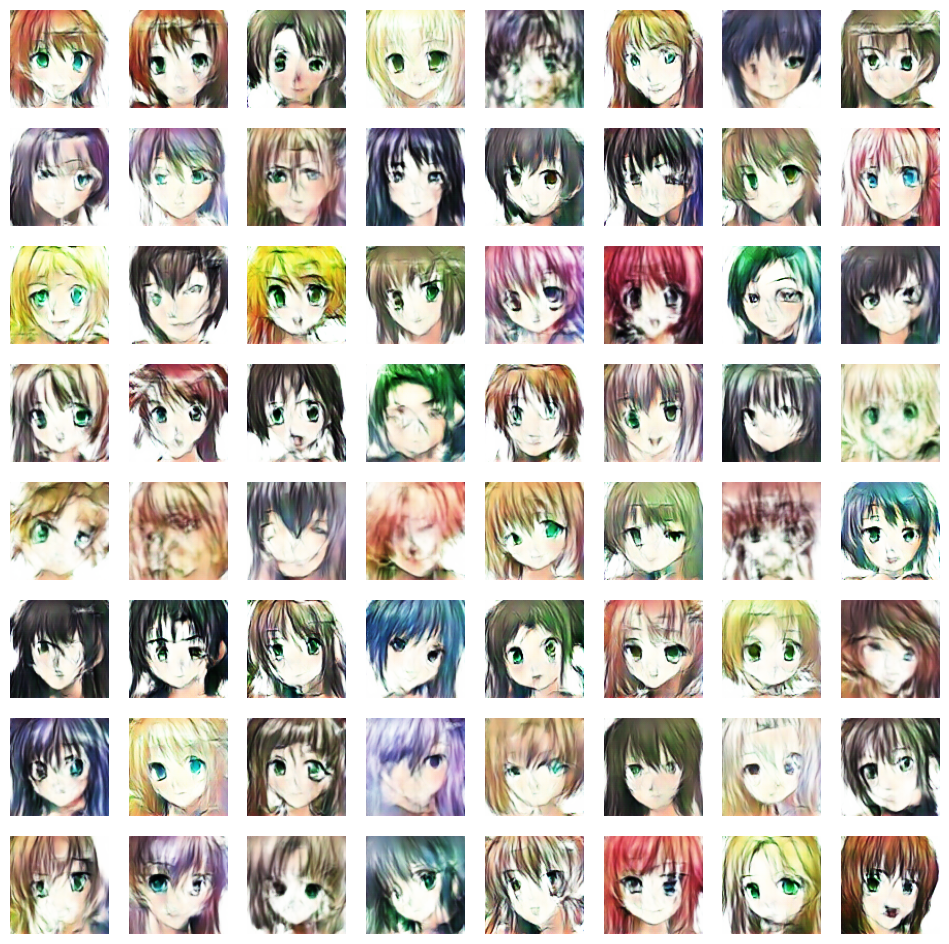

In [14]:
generate_faces()